<a href="https://colab.research.google.com/github/sammitako/CS-GY-6513-Big-Data/blob/master/Keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade spacy

In [ ]:
!pip install en_core_web_sm

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-Levenshtein

In [ ]:
!pip install taxonerd

In [ ]:
!pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_biobert-1.0.2.tar.gz

In [ ]:
# import libraries
import spacy
import csv
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
from rapidfuzz import process
import matplotlib.pyplot as plt
import plotly.express as px
import re
from collections import Counter
from taxonerd import TaxoNERD


# Selecting the column for species extraction.
>Upon analyzing the data, we discovered that the 'name', 'title', and 'product' columns contain identical data in the field. Therefore, we chose the 'product' column as it has the longest average text length.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BigData/TeamNotebook/data/preprocessed_data_file_geography_price_removed_outliers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64641 entries, 0 to 64640
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     64546 non-null  object 
 1   title                    64641 non-null  object 
 2   product                  64641 non-null  object 
 3   description              64239 non-null  object 
 4   domain                   64641 non-null  object 
 5   country                  50267 non-null  object 
 6   label_product            64641 non-null  object 
 7   price                    64641 non-null  float64
 8   currency                 64641 non-null  object 
 9   production_date          329 non-null    object 
 10  image                    64210 non-null  object 
 11  url                      64641 non-null  object 
 12  location                 5716 non-null   object 
 13  domain_country_code      64641 non-null  object 
 14  domain_country        

In [ ]:
avg_length_product = df['product_fingerprint'].apply(lambda x: len(str(x))).mean()
avg_length_name = df['name_fingerprint'].apply(lambda x: len(str(x))).mean()
avg_length_title = df['title_fingerprint'].apply(lambda x: len(str(x))).mean()

avg_lengths = {
    'product_fingerprint': avg_length_product,
    'name_fingerprint': avg_length_name,
    'title_fingerprint': avg_length_title
}

# Find the column with the longest average text length
column_with_longest_avg = max(avg_lengths, key=avg_lengths.get)
print(f"The column with the longest average text length is: {column_with_longest_avg} with an average length of {avg_lengths[column_with_longest_avg]}")

The column with the longest average text length is: product_fingerprint with an average length of 71.06888816695286


*Drop* the columns 'name', 'title', 'product', and 'description' from DataFrame and then rename the `*_fingerprint` columns to just the base column names (like 'name')

In [ ]:
df = df.drop(columns=['name', 'title', 'product', 'description'])

df = df.rename(columns={
    'name_fingerprint': 'name',
    'title_fingerprint': 'title',
    'product_fingerprint': 'product',
    'description_fingerprint': 'description'
})

# Reordering the columns
columns_first = ['name', 'title', 'product', 'description']
remaining_columns = [col for col in df.columns if col not in columns_first]
new_column_order = columns_first + remaining_columns
df = df[new_column_order]
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
0,20mm band flat leather men ostrich quick real ...,20mm 2199 band flat leather men ostrich piccli...,20mm 2199 band flat leather men ostrich piccli...,100 18mm 19mm 20mm 21mm 22mm about also any ar...,picclick.com,United States,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",com,NaN,22
1,1911 2893 african kuhnert ostrich,1911 2893 734 african kuhnert ostrich picclick,1911 2893 734 african kuhnert ostrich picclick,12 1911 2893 300gm2 600 african alle american ...,picclick.com,Germany,an animal body part,7.34,USD,NaN,https://www.picclickimg.com/ABAAAOSwYrtjm-Ii/2...,http://picclick.com/2893-Kuhnert-1911-African-...,"Kirchen - Herkersdorf, DE",com,NaN,7
2,1987 battle beastformers beasts condorassin fi...,1987 4599 battle beastformers beasts condorass...,1987 4599 battle beastformers beasts condorass...,1987 a action and any battle beastformers beas...,picclick.com,United States,an animal body part,45.99,USD,NaN,https://www.picclickimg.com/ZN0AAOSw6l9lB2yi/B...,http://picclick.com/BATTLE-BEASTS-1987-Condora...,"Fairdale, Kentucky, US",com,NaN,46
3,adjustable bring chain clavicle fish good koi ...,180 adjustable bring chain clavicle fish good ...,180 adjustable bring chain clavicle fish good ...,104 10pcs 116 12 126 149 155 174 177 1mm 215 2...,picclick.com,China,an animal body part,1.80,USD,NaN,https://www.picclickimg.com/tnsAAOSwDZljSbGz/B...,http://picclick.com/Bring-Good-Luck-Koi-Red-Fi...,"Yiwu, CN",com,NaN,2
4,1 38 bonus fl fossilized from hemipristis inch...,1 2499 38 bonus fl fossilized from hemipristis...,1 2499 38 bonus fl fossilized from hemipristis...,1 10 100 2 25 30 38 41 5 70 a also an and appr...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/mVoAAOSwPyReqhRO/F...,http://picclick.com/Fossilized-Hemipristis-Sha...,"Sarasota, Florida, US",com,NaN,25


# Data pre-processing: Removing duplicates.

In [ ]:
# product_fingerprint column.
df['product']

0        20mm 2199 band flat leather men ostrich piccli...
1           1911 2893 734 african kuhnert ostrich picclick
2        1987 4599 battle beastformers beasts condorass...
3        180 adjustable bring chain clavicle fish good ...
4        1 2499 38 bonus fl fossilized from hemipristis...
                               ...                        
64636    28494 antler christmas for novelty sale store ...
64637    28464 european for horns mount pronghorn sale ...
64638    28462 duck for mount sale scene store taxiderm...
64639                                  for ostrich results
64640    1165989 1930 antler ca cane carved fine item m...
Name: product, Length: 64641, dtype: object

In [ ]:
# The unique values that have duplicates
duplicate_values = df.loc[df['product'].duplicated(keep='first'), 'product'].unique()

print(len(duplicate_values))

7595


In [ ]:
print(duplicate_values[0])

carcharhinus deko ebay falciformis fisch fish philippinen praparat rezent seidenhai


In [ ]:
first_duplicate_value = duplicate_values[0]
rows_with_first_duplicate = df[df['product'] == first_duplicate_value]

rows_with_first_duplicate

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
21,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.at,Austria,an animal body part,89.80,EUR,NaN,https://i.ebayimg.com/images/g/LeEAAOSwgMhiM5Y...,https://www.ebay.at/itm/125208750695?amdata=en...,NaN,at,Austria,82
72,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.ch,Switzerland,an animal body part,86.64,CHF,NaN,https://i.ebayimg.com/images/g/7jkAAOSw6C5iM5Y...,https://www.ebay.ch/itm/125208750734?amdata=en...,NaN,ch,Switzerland,76
73,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.ch,Switzerland,an animal body part,92.43,CHF,NaN,https://i.ebayimg.com/images/g/IoAAAOSwU9xiM5Z...,https://www.ebay.ch/itm/125208751206?amdata=en...,NaN,ch,Switzerland,82
412,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.nl,Netherlands,an animal body part,79.80,EUR,NaN,https://i.ebayimg.com/images/g/Mt4AAOSwsjZiNGM...,https://www.ebay.nl/itm/125209615968?amdata=en...,NaN,nl,Netherlands,73
413,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.nl,Netherlands,an animal body part,79.80,EUR,NaN,https://i.ebayimg.com/images/g/Mt4AAOSwsjZiNGM...,https://www.ebay.nl/itm/125209615968?amdata=en...,NaN,nl,Netherlands,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62728,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.at,Austria,an animal body part,95.80,EUR,NaN,https://i.ebayimg.com/images/g/IoAAAOSwU9xiM5Z...,https://www.ebay.at/itm/125208751206?amdata=en...,NaN,at,Austria,87
63635,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,artikel auswahl bei carcharhinus deko der ebay...,ebay.de,Germany,an animal body part,89.80,EUR,NaN,https://i.ebayimg.com/images/g/BAEAAOSwb4tiM5Y...,https://www.ebay.de/itm/125208750598?amdata=en...,NaN,de,Germany,82
64173,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.nl,Netherlands,an animal body part,95.80,EUR,NaN,https://i.ebayimg.com/images/g/tV4AAOSwi5tiM5Z...,https://www.ebay.nl/itm/125208751276,NaN,nl,Netherlands,87
64174,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko ebay falciformis fisch fish ...,carcharhinus deko der ebay falciformis fisch f...,ebay.nl,Netherlands,an animal body part,79.80,EUR,NaN,https://i.ebayimg.com/images/g/66MAAOSwsNBiNGM...,https://www.ebay.nl/itm/125209615873?amdata=en...,NaN,nl,Netherlands,73


We observed that the same advertisements are posted on different URLs. Upon examination, we noted that the 'name', 'title', and 'product' are the same; however, the descriptions vary:

- Remove duplicate rows where 'name', 'title', and 'product' are the same.
- Remove duplicate rows where the description is the same.

In [ ]:
# Step 1
df = df.drop_duplicates(subset=['name', 'title', 'product'])

# Step 2
df = df.drop_duplicates(subset=['description'])

In [ ]:
# name, title, product: 51610 -> 17433 (-34177)
# description: 51306 -> 17432 (-33874)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20864 entries, 0 to 64640
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  20864 non-null  object 
 1   title                 20864 non-null  object 
 2   product               20864 non-null  object 
 3   description           20863 non-null  object 
 4   domain                20864 non-null  object 
 5   country               17198 non-null  object 
 6   label_product         20864 non-null  object 
 7   price                 20864 non-null  float64
 8   currency              20864 non-null  object 
 9   production_date       305 non-null    object 
 10  image                 20837 non-null  object 
 11  url                   20864 non-null  object 
 12  location              5357 non-null   object 
 13  domain_country_code   20864 non-null  object 
 14  domain_country        11926 non-null  object 
 15  normalized_price_us

In [ ]:
# product_fingerprint column.
df.head(10)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
0,20mm band flat leather men ostrich quick real ...,20mm 2199 band flat leather men ostrich piccli...,20mm 2199 band flat leather men ostrich piccli...,100 18mm 19mm 20mm 21mm 22mm about also any ar...,picclick.com,United States,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",com,NaN,22
1,1911 2893 african kuhnert ostrich,1911 2893 734 african kuhnert ostrich picclick,1911 2893 734 african kuhnert ostrich picclick,12 1911 2893 300gm2 600 african alle american ...,picclick.com,Germany,an animal body part,7.34,USD,NaN,https://www.picclickimg.com/ABAAAOSwYrtjm-Ii/2...,http://picclick.com/2893-Kuhnert-1911-African-...,"Kirchen - Herkersdorf, DE",com,NaN,7
2,1987 battle beastformers beasts condorassin fi...,1987 4599 battle beastformers beasts condorass...,1987 4599 battle beastformers beasts condorass...,1987 a action and any battle beastformers beas...,picclick.com,United States,an animal body part,45.99,USD,NaN,https://www.picclickimg.com/ZN0AAOSw6l9lB2yi/B...,http://picclick.com/BATTLE-BEASTS-1987-Condora...,"Fairdale, Kentucky, US",com,NaN,46
3,adjustable bring chain clavicle fish good koi ...,180 adjustable bring chain clavicle fish good ...,180 adjustable bring chain clavicle fish good ...,104 10pcs 116 12 126 149 155 174 177 1mm 215 2...,picclick.com,China,an animal body part,1.80,USD,NaN,https://www.picclickimg.com/tnsAAOSwDZljSbGz/B...,http://picclick.com/Bring-Good-Luck-Koi-Red-Fi...,"Yiwu, CN",com,NaN,2
4,1 38 bonus fl fossilized from hemipristis inch...,1 2499 38 bonus fl fossilized from hemipristis...,1 2499 38 bonus fl fossilized from hemipristis...,1 10 100 2 25 30 38 41 5 70 a also an and appr...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/mVoAAOSwPyReqhRO/F...,http://picclick.com/Fossilized-Hemipristis-Sha...,"Sarasota, Florida, US",com,NaN,25
5,art bathroom butt decor funny gift nice ostric...,1817 art bathroom butt decor funny gift nice o...,1817 art bathroom butt decor funny gift nice o...,117 12x16 165 18x24 234 24 260 83 9x12 a a2 a3...,picclick.com,United Kingdom,an animal body part,18.17,USD,NaN,https://www.picclickimg.com/SawAAOSwhU1kZn3q/F...,http://picclick.com/Funny-Ostrich-Poster-Vinta...,"Kettering, GB",com,NaN,18
6,5 alligator crocodile genuine head jaw real re...,2469 5 alligator crocodile genuine head jaw pi...,2469 5 alligator crocodile genuine head jaw pi...,5 alligator as be can caution condition crocod...,picclick.com,United States,an animal body part,24.69,USD,NaN,https://www.picclickimg.com/DYQAAOSwEDZkyTAL/G...,http://picclick.com/Genuine-Alligator-Head-5-S...,"Apache Junction, Arizona, US",com,NaN,25
7,animal figure fish furuta japan kaiyodo megamo...,1587 animal figure fish furuta japan kaiyodo m...,1587 animal figure fish furuta japan kaiyodo m...,1 100 299 30 46 5 9 a accept always an and ani...,picclick.com,Thailand,an animal body part,15.87,USD,NaN,https://www.picclickimg.com/6mgAAOSwNj5dFh8u/J...,http://picclick.com/Japan-Kaiyodo-Furuta-Megam...,"Muang, Samutprakarn, TH",com,NaN,16
8,beetle capsule cephalotes cissites figure hira...,999 beetle capsule cephalotes cissites figure ...,999 beetle capsule cephalotes cissites figure ...,27 30 4 5 7 a about accept additional address ...,picclick.com,Japan,an animal body part,9.99,USD,NaN,https://www.picclickimg.com/TFwAAOSwBiBjeyMY/K...,http://picclick.com/Kaiyodo-Capsule-Q-Museum-F...,"Kobe-shi, Hyogo-ken, JP",com,NaN,10
9,beetle exclusive figure insect japan japanese ...,1599 beetle exclusive figure insect japan japa...,1599 beetle exclusive figure insect japan japa...,a adults and any ask auctions available beetle...,picclick.com,Canada,an animal body part,15.99,USD,NaN,https://www.picclickimg.com/nw8AAOSwSqJfmcKO/K...,http:/

In [ ]:
final_file_path = '/content/drive/MyDrive/BigData/TeamNotebook/data/final_cleaned_data.csv'
df.to_csv(final_file_path, index=False)

# Data pre-processing: Removing rows not related to wildlife trafficking.

### We remove rows where the product description indicates that it might not be related to wildlife trading.
>From the dataset, we remove rows that have terms such as 'faux' and 'replica' in the product column which implies that the product is not a real animal or an animal body part. More examples: 'peluche' translates to stuffed toy, so we will remove those entries too.

In [ ]:
non_animal_product_list = ['faux','replica','toolbox','hardback','toy','figure','tool','book','peluche','juguete']

In [ ]:
df = df[~df['product'].str.contains('|'.join(non_animal_product_list), na=False)]

In [ ]:
df.shape[0]

19463

>Approximately 1000 entries are removed from the dataset.

### Retain rows that contains certain common keywords.
>In contrary to the previous approach, we can also assume that an ad listing is related to wildlife trafficking if the product column contain certain keywords. We load the pre-defined most common keywords from the 'common_kws.txt' file and retain those ad listings which have any matching keywords from the file.

In [ ]:
# Load the most common keywords and form a set of common words.
common_kws =  set(open('/content/drive/MyDrive/BigData/TeamNotebook/data/common_kws.txt').read().lower().split())

In [ ]:
print(common_kws)

{'deep', 'owl', 'caviar', 'otter', 'bile', 'bear', 'python', 'faux', 'monkey', 'hide', 'antique', 'carving', 'horn', 'falcon', 'paw', 'crocodile', 'ox', 'eagle', 'sparrowhawk', 'tortoise', 'ocelot', 'goshawk', 'carved', 'rhinoceros', 'feather', 'prey', 'teeth', 'lynx', 'grain', 'bird', 'alligator', 'cow', 'tooth', 'gorilla', 'egg', 'clam', 'turtle', 'elephant', 'taxidermy', 'fur', 'feet', 'colored', 'tusk', 'primate', 'netsuke', 'claw', 'shell', 'cross-hatch', 'lizard', 'skeleton', 'leopard', 'carcass', 'fake', 'natural', 'skin', 'macaque', 'oil', 'pelt', 'snake', 'patina', 'chinese', 'live', 'cites', 'of', 'shatoosh', 'cheetah', 'macaw', 'birds', 'lion', 'coloured', 'trophy', 'varanus', 'ivory', 'skull', 'hair', 'reptile', 'shark', 'cobra', 'pangolin', 'excotic', 'wildlife', 'meat', 'schreger', 'material', 'scrimshaw', 'graining', 'lemur', 'lines', 'ivy', 'chimpanzee', 'parrot', 'okimono', 'pet', 'boa', 'bovine', 'leather', 'foot', 'ivorine', 'bone', 'scale', 'tiger'}


In [ ]:
# Retain the rows that contain any matching common keywords.
df = df[df['product'].str.contains('|'.join(common_kws), na=False)]

In [ ]:
df.head(5)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
0,20mm band flat leather men ostrich quick real ...,20mm 2199 band flat leather men ostrich piccli...,20mm 2199 band flat leather men ostrich piccli...,100 18mm 19mm 20mm 21mm 22mm about also any ar...,picclick.com,United States,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",com,NaN,22
4,1 38 bonus fl fossilized from hemipristis inch...,1 2499 38 bonus fl fossilized from hemipristis...,1 2499 38 bonus fl fossilized from hemipristis...,1 10 100 2 25 30 38 41 5 70 a also an and appr...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/mVoAAOSwPyReqhRO/F...,http://picclick.com/Fossilized-Hemipristis-Sha...,"Sarasota, Florida, US",com,NaN,25
6,5 alligator crocodile genuine head jaw real re...,2469 5 alligator crocodile genuine head jaw pi...,2469 5 alligator crocodile genuine head jaw pi...,5 alligator as be can caution condition crocod...,picclick.com,United States,an animal body part,24.69,USD,NaN,https://www.picclickimg.com/DYQAAOSwEDZkyTAL/G...,http://picclick.com/Genuine-Alligator-Head-5-S...,"Apache Junction, Arizona, US",com,NaN,25
10,2013 africa crocodile fauna mint nh nile of sa...,1695 2013 africa crocodile fauna mint nh nile ...,1695 2013 africa crocodile fauna mint nh nile ...,10 100 1000 10000 2 2013 23 250 5000 a about a...,picclick.com,United States,an animal body part,16.95,USD,NaN,https://www.picclickimg.com/px8AAOxy9ERSRJab/S...,http://picclick.com/Sao-Tome-2013-Fauna-Of-Afr...,"Great Neck, New York, US",com,NaN,17
12,1987 5050 80s and minnesota shirt single soft ...,1987 2499 5050 80s and minnesota picclick shir...,1987 2499 5050 80s and minnesota picclick shir...,1987 24 5050 80s adult advantage and condition...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/nPwAAOSwwRplDPDU/V...,http://picclick.com/Vintage-80s-Wolf-Minnesota...,"Philadelphia, Pennsylvania, US",com,NaN,25


In [ ]:
df.shape[0]

10506

When considering rows that contains any of the common keywords, the data is further reduced.

# Data pre-processing - 'product' column for species extraction.
To extract the species from each row, we tokenize the product column in an attempt to find relevant keywords. But the column contains a lot of text, most of which are irrelevant to the species name. By removing these words, we remove the low-level information from the product description in order to give more focus to the species name.

### Removing stopwords, numerals and other irreleavant words.
Stopwords are the most common words in any language (ex. articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”.
>We will also remove numerals, verbs, and other words which are not relavant to species name.
>The removal of such words will not have any negative consequences for our task. It reduces the number of tokens and leads to a more accurate species extraction.

In [ ]:
# product column.
df['product'].head(10)

0     20mm 2199 band flat leather men ostrich piccli...
4     1 2499 38 bonus fl fossilized from hemipristis...
6     2469 5 alligator crocodile genuine head jaw pi...
10    1695 2013 africa crocodile fauna mint nh nile ...
12    1987 2499 5050 80s and minnesota picclick shir...
15    1499 6 cub large medium picclick pick shirt si...
16    13500 alligator card case credit envelope gato...
18    1499 349mm clamp picclick red seatpost tooth wolf
26    ebay great jewelry ring sea shark signet silve...
27    1914 50 and beetles card ebay garden ground li...
Name: product, dtype: object

In [ ]:
# Loading the english language small model of spacy
en = spacy.load("en_core_web_sm")

Spacy is used to tokenize text and after tokenization, it can parse and tag a given Doc.
The trained pipeline enables spaCy to make predictions of which tag or label most likely applies in this context.

In [ ]:
df['product'].head(10).iloc[1]

'1 2499 38 bonus fl fossilized from hemipristis inch items picclick shark tooth venice'

In [ ]:
# Example of using spaCy to tokenize and tag a Doc.
original_text = "contortus ebay hill miocene physogaleus shark sharktooth tiger tooth"
doc = en(original_text.lower())
for token in doc:
    print(token.text, token.pos_)

contortus PROPN
ebay PROPN
hill PROPN
miocene PROPN
physogaleus PROPN
shark PROPN
sharktooth NOUN
tiger NOUN
tooth NOUN


In [ ]:
# Only nouns, proper nouns and adjectives will be retained from the text.
def retain_words_with_tags(text):
    result = []
    pos_tags = ['PROPN', 'NOUN', 'ADJ']
    doc = en(text.lower())

    words = [token.text for token in doc if token.pos_ in pos_tags]

    result = ' '.join(words)

    return result

In [ ]:
# Example of using spaCy to retain PROPN, NOUN and ADJ tags.
original_text = "adornment ears ebay fox hair headband headdress plush props sets suit tail wolf"
filtered_text = retain_words_with_tags(original_text)
print(filtered_text)

adornment ears ebay fox hair headband headdress plush props suit wolf


In [ ]:
# Another example.
original_text = "This is the 3rd example sentence with nouns like cat and dog."
filtered_text = retain_words_with_tags(original_text)
print(filtered_text)

3rd example sentence nouns cat dog


We will populate a new column 'product_cleaned' that will be used to retain keywords for species extraction.

In [ ]:
df['product_cleaned'] = df['product'].apply(retain_words_with_tags)

In [ ]:
# cleaned product column after retaining PROPN, NOUN and ADJ tags.
df['product_cleaned'].head(10)

NameError: ignored

# Species extraction using TaxoNERD
TaxoNERD is a domain-specific tool for recognizing taxon mentions in the biodiversity literature.
We will use the 'en_core_eco_biobert' model to extract species name from the text in the pre-processed 'product' column.

In [ ]:
taxonerd = TaxoNERD(prefer_gpu=False)

In [ ]:
# Load taxonerd model
nlp = taxonerd.load(model="en_core_eco_biobert")

In [ ]:
example_text1 = df['product_cleaned'].head(10).iloc[2]
print(example_text1)

alligator crocodile genuine head jaw picclick real reptile skull swamp taxidermy teeth


In [ ]:
# Example of using taxonerd to extract species from text.
taxonerd.find_in_text(example_text1)

,offsets,text,sent
T0,LIVB 0 19,alligator crocodile,0


In [ ]:
example_text2 = df['product_cleaned'].head().iloc[0]
print(example_text2)

band flat leather men ostrich picclick quick real red release strap watch


In [ ]:
# An example where taxonerd does not work.
taxonerd.find_in_text(example_text2)

""


>Taxonerd does not perform well with long strings, so will remove some irrelevant words.

### Remove irrelevant common words.
Find the most common words that are irrelevant for species extraction and remove them from the 'product_cleaned' column.

In [ ]:
from collections import Counter

In [ ]:
# The most common 800 words.
common_words = [i[0] for i in Counter(" ".join(df['product_cleaned']).split()).most_common()[:800]]

These are the most common words in the 'product_cleaned' column. To make species extraction faster and accurate, we will remove some of these words which are not part of the 'common_kws.txt' file

In [ ]:
# From the list of illegal animals, form a set of keywords.
split_words = [word for phrase in illegal_animal_list for word in phrase.split()]
illegal_animal_kws = set(split_words)

In [ ]:
print(illegal_animal_kws)

In [ ]:
irrelevant_common_words = [word for word in common_words if word not in common_kws and word not in illegal_animal_kws]

In [ ]:
print(irrelevant_common_words)

['ebay', 'picclick', 'mens', 'black', 'boots', 'size', 'fossil', 'cowboy', 'new', 'brown', 'genuine', 'vintage', 'jaws', 'western', 'megalodon', 'blue', 'animal', 'head', 'real', 'tshirt', 'silver', 'shirt', 'necklace', 'pendant', 'mm', 'sale', 'large', 'trade', 'fish', 'pcs', 'mnh', 'full', 'toe', 'men', 'cm', 'exotic', 'd', 'red', 'inch', 'jaw', 'ebid', 'womens', 'nil', 'wild', 'feathers', 'lot', 't', 'quill', 'bag', 'art', 'rare', 'florida', 'decor', 'xl', 'plush', 'lucchese', 'soft', 'sharks', 'ocean', 'high', 'w', 'coin', 'usa', 'free', 'sea', 'handmade', 'top', 'statue', 'box', 'wallet', 'pack', 'leg', 'mount', 'gift', 'mako', 'hand', 'monster', 'green', 'bull', 'square', 'united', 'card', 'lama', 'quality', 'baby', 'wolves', 'du', 'kingdom', 'shoes', 'figurine', 'l', 'nike', 'ee', 'tony', 'decoration', 'small', 'air', 'collection', 'c', 'crocodiles', 'party', 'gold', 'vinyl', 'de', 'strap', 'christmas', 'women', 'tee', 'dress', 'american', 'belt', 'sz', 'boot', 'diver', 'fishing

In [ ]:
len(irrelevant_common_words)

735

In [ ]:
def remove_irrelevant_words(text):
    # Tokenize the text
    words = text.split()

    # Remove irrelevant words
    words = [word for word in words if word.lower() not in irrelevant_common_words]

    cleaned_text = ' '.join(words)

    return cleaned_text

In [ ]:
df['product_cleaned'] = df['product_cleaned'].apply(remove_irrelevant_words)

In [ ]:
df['product_cleaned'].tail(10)

17399                                                tiger
17401                                                teeth
17407                             proximus scitulus tachys
17418                     merops niloticus nubicus varanus
17419                                       mastige proofs
17427                              great iuuou shark white
17428    crocodile dollars iaia islands nile solomon sp...
17429                                    ieatanzania polar
17431                              bone iiblue shark tooth
17432                                          shark white
Name: product_cleaned, dtype: object

After removing irrelevant words from the 'product_cleaned' column, some rows are left empty for this column. So, we will remove them from our dataset.

In [ ]:
df = df[~(df['product_cleaned'] == '')]

In [ ]:
df.shape[0]

8628

We removed around 50 rows.

## Applying taxonerd on cleaned data.

In [ ]:
def get_species(name):
    try:
        doc = nlp(name)
        return doc.ents[0]
    except:
        return None

In [ ]:
df['taxo_species'] = df['product_cleaned'].apply(get_species)

In [ ]:
df.head(5)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,product_cleaned,species
0,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and at best bones color deals ebay ...,ebay.com.au,Australia,an animal body part,22.25,AUD,NaN,https://images.awesomebooks.com/images/books/r...,https://www.ebay.com.au/itm/384104329587?amdat...,NaN,au,Australia,34,adventures hailstones mary oneill,None
1,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,and at best contortus deals delivery ebay find...,ebay.co.uk,United Kingdom,an animal body part,12.63,GBP,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.co.uk/itm/222613331802,NaN,uk,United Kingdom,10,contortus hill physogaleus shark sharktooth ti...,(contortus)
2,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,and at azaz best contortus deals ebay find for...,ebay.com,NaN,an animal body part,111.39,CNY,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.com/itm/222613331802?_ul=CN,NaN,com,NaN,790,azaz contortus hill physogaleus sharktooth,"(azaz, contortus)"
5,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada and at best brinquedo d de deals ebay...,ebay.com,NaN,an animal body part,74.43,EUR,NaN,https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxO...,https://www.ebay.com/itm/155807567987?_ul=PT,NaN,com,NaN,68,almofada estereo gato peca pelucia simulado tr...,None
7,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,black crafts decorations dining ebay feathers ...,and at best black crafts deals decorations del...,ebay.co.uk,United Kingdom,an animal body part,9.58,GBP,NaN,https://i.ebayimg.com/images/g/Q1IAAOSws29lGwl...,https://www.ebay.co.uk/itm/314864391496?amdata...,NaN,uk,United Kingdom,8,decorations federn kanstliche ostrich,None


In [ ]:
df['taxo_species'].notna().sum()

3666

>We analyzed the result of using Taxnerd for species extraction and concluded that most of the rows contain 'None' values. Taxonerd also returned multiple species name for some of the rows. This might be an indication that Taxonerd is not the most appropriate tool for our task. We will try another approach for species extraction focusing more on string matching.

# Species extraction from the product column using String matching.

## Fuzzy String Matching
We will use rapidfuzzy, a python library for comparing text based on the similarity of strings. The library uses Levenshtein distance to calculate the difference between two strings. It is an alternative to the fuzzywuzzy library and provides fast and efficient string matching and fuzzy string matching functions.

Partial Ratio: It finds the ratio similarity measure between the shorter string and every substring of length m of the longer string, and returns the maximum of those similarity measures. Basically, it searches for the optimal alignment of the shorter string in the longer string and returns the fuzz.ratio for this alignment.

The extractOne function returns a tuple containing the best matching string and its similarity score. The similarity score is computed using the token set ratio as specified in the parameters.


In [ ]:
# Example of using rapidfuzz string matching.
example_text = df['product_cleaned'].head(10).iloc[4]
print(example_text)

80s minnesota picclick shirt single soft stitched t thin vintage wolf


In [ ]:
fuzz.partial_ratio(example_text, "wolf")

100.0

In [ ]:
fuzz.partial_ratio("silkyshark listing", "silky shark")

95.23809523809523

>The 'final_animal_list.csv' file contains 8130 entries of animal species names. It contains normalized Specific species name and also their General names and we will use the Specific names to form a list of animals.
We will check if our dataset contains any of the animals listed here.
Using similarity search, we will compare the long text in the 'product_cleaned' column and find if any part of that text matches with anything in the animal list.

In [ ]:
animal_list_df = pd.read_csv('/content/drive/MyDrive/BigData/TeamNotebook/data/final_animal_list.csv')
animal_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8130 entries, 0 to 8129
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Distribution Country       8047 non-null   object
 1   Specific Names             8130 non-null   object
 2   Specific Names Normalized  8130 non-null   object
 3   General Names Normalized   8130 non-null   object
dtypes: object(4)
memory usage: 254.2+ KB


In [ ]:
animal_list_df.head()

,Distribution Country,Specific Names,Specific Names Normalized,General Names Normalized
0,"Angola, Botswana, Central African Republic, Dj...",Aardwolf,aardwolf,aardwolf
1,Bahamas,Abaco Island Boa,abaco island boa,boa
2,"Australia, Christmas Island, Indonesia, Maurit...",Abbott's Booby,abbotts booby,booby
3,"Madagascar, Seychelles",Abbott's Day Gecko,abbotts day gecko,gecko
4,Italy,Abruzzo Chamois,abruzzo chamois,chamois


In [ ]:
animal_list = animal_list_df['Specific Names Normalized'].tolist()

In [ ]:
animal_list

['aardwolf',
 'abaco island boa',
 'abbotts booby',
 'abbotts day gecko',
 'abruzzo chamois',
 'abyssinian longeared owl',
 'abyssinian lovebird',
 'abyssinian owl',
 'acapulco lesser orange tarantula',
 'achoque',
 'acklins ground iguana',
 'adalberts eagle',
 'addax',
 'addra gazelle',
 'admiralty cuscus',
 'admiralty flyingfox',
 'admiralty hawkowl',
 'admiralty island cuscus',
 'admiralty islands hawkowl',
 'adorable coquette',
 'adriatic sturgeon',
 'afghan fox',
 'afghan tortoise',
 'afghan urial',
 'african ass',
 'african barred owlet',
 'african bay owl',
 'african baza',
 'african black eagle',
 'african blind barb',
 'african blind barb fish',
 'african burrowing python',
 'african caracal',
 'african chameleon',
 'african civet',
 'african clawless otter',
 'african comb duck',
 'african crocodile',
 'african crowned eagle',
 'african cuckoofalcon',
 'african cuckoohawk',
 'african dwarf crocodile',
 'african eagle',
 'african eagleowl',
 'african elephant',
 'african fishe

In [ ]:
# Check if any part of the text matches with items in the search_list
def find_best_match(text, search_list):
    best_match, score, index = process.extractOne(text, search_list, scorer=fuzz.token_set_ratio)
    threshold = 90
    if score >= threshold:
        return best_match
    else:
        return None

The 'find_best_match' function returns the best match if any part of the text has a token_set_ratio greater than 95 with any item in the search list. The 'product_cleaned' might have more than one potential match, but we will consider the best match out of all the potential matches. The threshold is set to 95 as we are trying to find the exact spacies name.

In [ ]:
# Apply the similarity search function to the 'product_cleaned' column
df['species'] = df['product_cleaned'].apply(lambda x: find_best_match(x, animal_list))

In [ ]:
df[['product_cleaned','species']].head()

,product_cleaned,species
0,band flat leather men ostrich picclick quick r...,ostrich
4,bonus hemipristis inch items picclick shark to...,None
6,alligator crocodile genuine head jaw picclick ...,None
10,africa crocodile fauna mint nile picclick sao ...,nile crocodile
12,80s minnesota picclick shirt single soft stitc...,wolf


In [ ]:
df['species'].notna().sum()

6411

We were able to find the species name for 6411 rows.

## Finding the most commonly traded animal species

In [ ]:
wildlife_count = df['species'].value_counts().reset_index()
wildlife_count.columns = ['species', 'count']
wildlife_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   species  128 non-null    object
 1   count    128 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
wildlife_count.head(10)

,species,count
0,ostrich,1586
1,great white shark,1533
2,wolf,948
3,tiger,701
4,nile crocodile,534
5,blue shark,129
6,crocodiles,77
7,silky shark,76
8,white shark,73
9,bull shark,73


# Visulization of illegal wildlife trade.

In [ ]:
fig = px.pie(wildlife_count.head(10), values='count', names='species',
             title='Top 10 traded animals')
fig.show()

In [ ]:
fig = px.bar(wildlife_count.head(20), y='count', x='species', color='species',
             title="Top 20 traded animals", text=wildlife_count.head(20)['count'].astype(str))
fig.show()

In [ ]:
wildlife_trade_df = df[df['species'].notna()]
wildlife_trade_country_count = wildlife_trade_df['country'].value_counts().reset_index()
wildlife_trade_country_count.columns = ['country', 'count']

In [ ]:
wildlife_trade_country_count.head(10)

,country,count
0,United States,1528
1,Australia,542
2,United Kingdom,518
3,Philippines,413
4,Canada,402
5,France,279
6,Singapore,255
7,Ireland,252
8,Netherlands,200
9,Hong Kong,165


In [ ]:
fig = px.choropleth(wildlife_trade_country_count, locations="country", locationmode='country names',
                    color="count", hover_name="country", projection='natural earth',
                    title='Geographical distribution of wildlife trade ad listings')

fig.show()

# Price range of wildlife traded online.

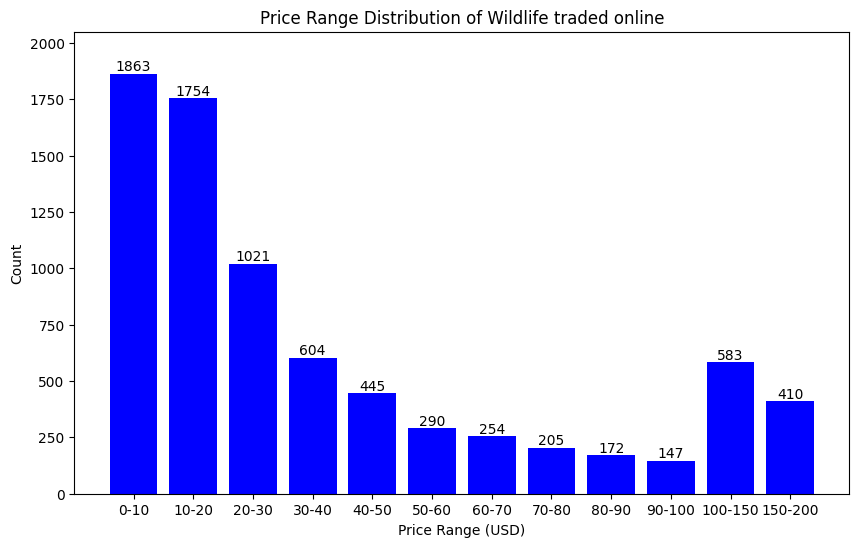

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-150', '150-200']
df['price_range'] = pd.cut(df['normalized_price_usd'], bins=bins, labels=labels, right=False)

price_range_counts = df['price_range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(price_range_counts.index.astype(str), price_range_counts.values, color='blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Price Range (USD)')
plt.ylabel('Count')
plt.title('Price Range Distribution of Wildlife traded online')

plt.ylim(0, price_range_counts.max() * 1.1)

plt.show()

# Using the master data of top 10 illegally traded wildlife.
The master data 'animals_paper_top10.txt' contains the list of top 10 animals that are illegal to trade and are in danger of extinction. We will find if our dataset contains any of the animals listed here.

### Master data with lists of animals that are illegal to trade and are in danger of extinction
The data contains the common names and the scientific names of the animals.

In [ ]:
illegal_animal_list = open('/content/drive/MyDrive/BigData/TeamNotebook/data/animals_paper_top10.txt').read().lower().split('\n')

In [ ]:
illegal_animal_list

['struthio camelus',
 'ostrich',
 'canis lupus',
 'wolf',
 'carcharhinus falciformis',
 'silky shark',
 'carcharhinus longimanus',
 'great white shark',
 'carcharias taurus',
 'sand tiger shark',
 'caiman latirostris',
 'caiman latirostris',
 'hippoglossus hippoglossus',
 'halibut',
 'calathus lundbladi',
 'ground beetle',
 'crocodylus niloticus',
 'nile crocodile',
 'sebastes fasciatus',
 'redfish']

In [ ]:
# Apply the similarity search function to the 'product_cleaned' column
df['endangered_species'] = df['product_cleaned'].apply(lambda x: find_best_match(x, illegal_animal_list))

In [ ]:
df[['product_cleaned','endangered_species']].head()

,product_cleaned,endangered_species
0,band flat leather men ostrich picclick quick r...,ostrich
4,bonus hemipristis inch items picclick shark to...,None
6,alligator crocodile genuine head jaw picclick ...,None
10,africa crocodile fauna mint nile picclick sao ...,nile crocodile
12,80s minnesota picclick shirt single soft stitc...,wolf


In [ ]:
illegal_trade_df = df[df['endangered_species'].notna()]

In [ ]:
illegal_trade_df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,product_cleaned,species,price_range,endangered_species
0,20mm band flat leather men ostrich quick real ...,20mm 2199 band flat leather men ostrich piccli...,20mm 2199 band flat leather men ostrich piccli...,100 18mm 19mm 20mm 21mm 22mm about also any ar...,picclick.com,United States,an animal body part,21.99,USD,NaN,https://www.picclickimg.com/4asAAOSwAatkmpPo/2...,http://picclick.com/20mm-Red-Leather-Watch-Str...,"Houston, Texas, US",com,NaN,22,band flat leather men ostrich picclick quick r...,ostrich,20-30,ostrich
10,2013 africa crocodile fauna mint nh nile of sa...,1695 2013 africa crocodile fauna mint nh nile ...,1695 2013 africa crocodile fauna mint nh nile ...,10 100 1000 10000 2 2013 23 250 5000 a about a...,picclick.com,United States,an animal body part,16.95,USD,NaN,https://www.picclickimg.com/px8AAOxy9ERSRJab/S...,http://picclick.com/Sao-Tome-2013-Fauna-Of-Afr...,"Great Neck, New York, US",com,NaN,17,africa crocodile fauna mint nile picclick sao ...,nile crocodile,10-20,nile crocodile
12,1987 5050 80s and minnesota shirt single soft ...,1987 2499 5050 80s and minnesota picclick shir...,1987 2499 5050 80s and minnesota picclick shir...,1987 24 5050 80s adult advantage and condition...,picclick.com,United States,an animal body part,24.99,USD,NaN,https://www.picclickimg.com/nPwAAOSwwRplDPDU/V...,http://picclick.com/Vintage-80s-Wolf-Minnesota...,"Philadelphia, Pennsylvania, US",com,NaN,25,80s minnesota picclick shirt single soft stitc...,wolf,20-30,wolf
18,349mm clamp red seatpost tooth wolf,1499 349mm clamp picclick red seatpost tooth wolf,1499 349mm clamp picclick red seatpost tooth wolf,349 349mm a bikes bought clamp for mikes new n...,picclick.com,United States,an animal body part,14.99,USD,NaN,https://www.picclickimg.com/p~8AAOSwCqllF1gl/W...,http://picclick.com/Wolf-Tooth-Seatpost-Clamp-...,"Doylestown, Pennsylvania, US",com,NaN,15,mm clamp picclick red seatpost tooth wolf,wolf,10-20,wolf
26,ebay great jewelry ring sea shark signet silve...,ebay great jewelry ring sea shark signet silve...,ebay great jewelry ring sea shark signet silve...,ebay fine great jewellery jewelry ring rings s...,ebay.at,Austria,an animal body part,888.22,EUR,NaN,https://i.ebayimg.com/images/g/D2wAAOSwTShi6~1...,https://www.ebay.at/itm/186038219614?amdata=en...,NaN,at,Austria,811,great jewelry ring sea shark signet silver white,great white shark,NaN,great white shark


In [ ]:
illegal_trade_df.shape[0]

5567

Around 5000 rows in our dataset are potential wildlife trading.

# Visulization of the top 10 illegally traded wildlife.

In [ ]:
illegal_trade_count = illegal_trade_df['endangered_species'].value_counts().reset_index()
illegal_trade_count.columns = ['endangered_species', 'count']

In [ ]:
illegal_trade_count

,endangered_species,count
0,great white shark,1609
1,ostrich,1567
2,wolf,1026
3,nile crocodile,571
4,sand tiger shark,216
5,halibut,146
6,crocodylus niloticus,85
7,silky shark,85
8,struthio camelus,78
9,redfish,51


The illegal_animal_list have both the common names and scientific names of the top 10 illegally traded animals. We will now combine the rows with the same species name to get a total count.

In [ ]:
species_names_mapping = {
    'struthio camelus': 'ostrich',
    'canis lupus': 'wolf',
    'carcharhinus falciformis': 'silky shark',
    'carcharhinus longimanus': 'great white shark',
    'carcharias taurus': 'sand tiger shark',
    'hippoglossus hippoglossus': 'halibut',
    'calathus lundbladi': 'ground beetle',
    'struthio camelus': 'ostrich',
    'crocodylus niloticus': 'nile crocodile',
    'sebastes fasciatus': 'redfish'
}

In [ ]:
for index, row in illegal_trade_count.iterrows():
    if row['endangered_species'] in species_names_mapping:
        illegal_trade_count.at[index, 'endangered_species'] = species_names_mapping[row['endangered_species']]

In [ ]:
illegal_trade_count

,endangered_species,count
0,great white shark,1609
1,ostrich,1567
2,wolf,1026
3,nile crocodile,571
4,sand tiger shark,216
5,halibut,146
6,nile crocodile,85
7,silky shark,85
8,ostrich,78
9,redfish,51


In [ ]:
top_10_illegally_traded_wildlife = illegal_trade_count.groupby('endangered_species')['count'].sum().reset_index()

In [ ]:
top_10_illegally_traded_wildlife

,endangered_species,count
0,caiman latirostris,40
1,great white shark,1612
2,ground beetle,31
3,halibut,150
4,nile crocodile,656
5,ostrich,1645
6,redfish,52
7,sand tiger shark,226
8,silky shark,87
9,wolf,1068


In [ ]:
import plotly.express as px

In [ ]:
fig = px.pie(top_10_illegally_traded_wildlife, values='count', names='endangered_species',
             title='Top 10 Illegally traded animals')
fig.show()

In [ ]:
fig = px.bar(top_10_illegally_traded_wildlife, y='count', x='endangered_species', color='endangered_species',
             title="Top 10 Illegally traded animals", text=top_10_illegally_traded_wildlife['count'].astype(str))
fig.show()

In [ ]:
illegal_trade_country_count = illegal_trade_df['country'].value_counts().reset_index()
illegal_trade_country_count.columns = ['country', 'count']

In [ ]:
illegal_trade_country_count.head(10)

,country,count
0,United States,1177
1,Australia,501
2,United Kingdom,499
3,Philippines,376
4,Canada,345
5,Ireland,244
6,Singapore,235
7,France,232
8,Netherlands,184
9,Hong Kong,170


In [ ]:
fig = px.choropleth(illegal_trade_country_count, locations="country", locationmode='country names',
                    color="count", hover_name="country", projection='natural earth',
                    title='Geographical distribution of ad listings that is a potential Illegal wildlife trade')

fig.show()

# References
https://spacy.io/usage/linguistic-features#morphology

https://www.analyticsvidhya.com/blog/2022/03/keyword-extraction-methods-from-documents-in-nlp/#h-spacy

https://pypi.org/project/taxonerd/

https://pypi.org/project/fuzzywuzzy/

https://medium.com/mlearning-ai/all-about-rapidfuzz-string-similarity-and-matching-cd26fdc963d8#:~:text=3.,the%20ratio%20will%20be%20100.

https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

https://www.analyticsvidhya.com/blog/2021/06/fuzzywuzzy-python-library-interesting-tool-for-nlp-and-text-analytics/